# Group 35 Project Report

## Introduction

Heart disease is a very general term that describes a range of conditions that are often very detrimental to one's health. A main concern for many forms of heart disease is the narrowing of vessels, which leads to higher risk of blockages, and therefore death. There are many contributers to the presence of heart disease in a person, including sex, age, cholesterol levels, heart rate, and blood pressure. As one gets older, the heart may begin to weaken and the vessels may narrow. A build-up of cholesterol on the vessel walls also narrows the vessels, and high blood pressure can harden and/or thicken the vessel walls, causing them to narrow.

The data below has been collected from 294 different patients and reports on specific aspects of their health with the purpose of determining the presence of heart disease. Similar data has been collected from hospitals  in Cleveland, Hungary, Switzerland, and the VA Long Beach. The data we are working with contains 14 variables/columns, and is taken from the Hungarian Institute of Cardiology in Budapest. 

The question to be answered is: Is heart disease in a patient based on their age, resting blood pressure, cholesteral levels, and maximum heart rate?

## Data Analysis

In [14]:
# Load package
library(tidyverse)
library(tidymodels)
library(digest)
library(GGally)
library(repr)
library(ISLR)
options(repr.matrix.max.rows = 6)

In [15]:
# Read in the heart disease data, rename the column name and mutate all columns to be numeric
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/reprocessed.hungarian.data"
heart_disease <- read_delim(url, delim = " ", col_names = FALSE) %>%
                    rename(age = X1, sex = X2, chest_pain_type = X3, resting_BP = X4, cholesterol = X5, fasting_bs = X6, rest_ecg = X7,
                           max_hr = X8, ex_angina = X9, st_depression = X10, slope_st = X11, num_major_vessels = X12, thal = X13, diagnosis = X14)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_double(),
  X13 = col_double(),
  X14 = col_double()
)



In [16]:
# Mutate the diagnosis to be factors, and age, resting_BP, cholesteral, max_hr to be integer
heart_disease <- heart_disease %>%
                mutate(diagnosis = as.factor(diagnosis))%>%
                mutate(age = as.integer(age))%>%
                mutate(resting_BP = as.integer(resting_BP))%>%
                mutate(cholesterol = as.integer(cholesterol))%>%
                mutate(max_hr = as.integer(max_hr))

# Replace all "-9" as NA
heart_disease <- heart_disease %>%
                 mutate(across(where(is.numeric), ~na_if(., -9)))

# Replace "1","2","3","4" as "1"
heart_disease <- heart_disease %>%                
                    mutate(diagnosis = replace(diagnosis, diagnosis != "0", "1"))

# Select age, resting_BP, cholesteral, and mx_hr columns, remove any rows that contain NA
heart_disease_data <- heart_disease %>%
                      select(age, resting_BP, cholesterol, max_hr, diagnosis) %>%
                      na.omit() 
heart_disease_data

age,resting_BP,cholesterol,max_hr,diagnosis
<int>,<int>,<int>,<int>,<fct>
40,140,289,172,0
49,160,180,156,1
37,130,283,98,0
⋮,⋮,⋮,⋮,⋮
48,110,211,138,0
47,140,257,135,0
53,130,182,148,0


In [17]:
# Set the seed
set.seed(999) 

# Split the data into a training and test set

heart_disease_split <- initial_split(heart_disease_data, prop = 0.75, strata = diagnosis)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split)

heart_disease_train
heart_disease_test

age,resting_BP,cholesterol,max_hr,diagnosis
<int>,<int>,<int>,<int>,<fct>
40,140,289,172,0
49,160,180,156,1
39,120,339,170,0
⋮,⋮,⋮,⋮,⋮
51,110,190,120,0
36,120,166,180,0
48,110,211,138,0


age,resting_BP,cholesterol,max_hr,diagnosis
<int>,<int>,<int>,<int>,<fct>
37,130,283,98,0
48,138,214,108,1
58,136,164,99,1
⋮,⋮,⋮,⋮,⋮
55,110,344,160,0
47,140,257,135,0
53,130,182,148,0


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



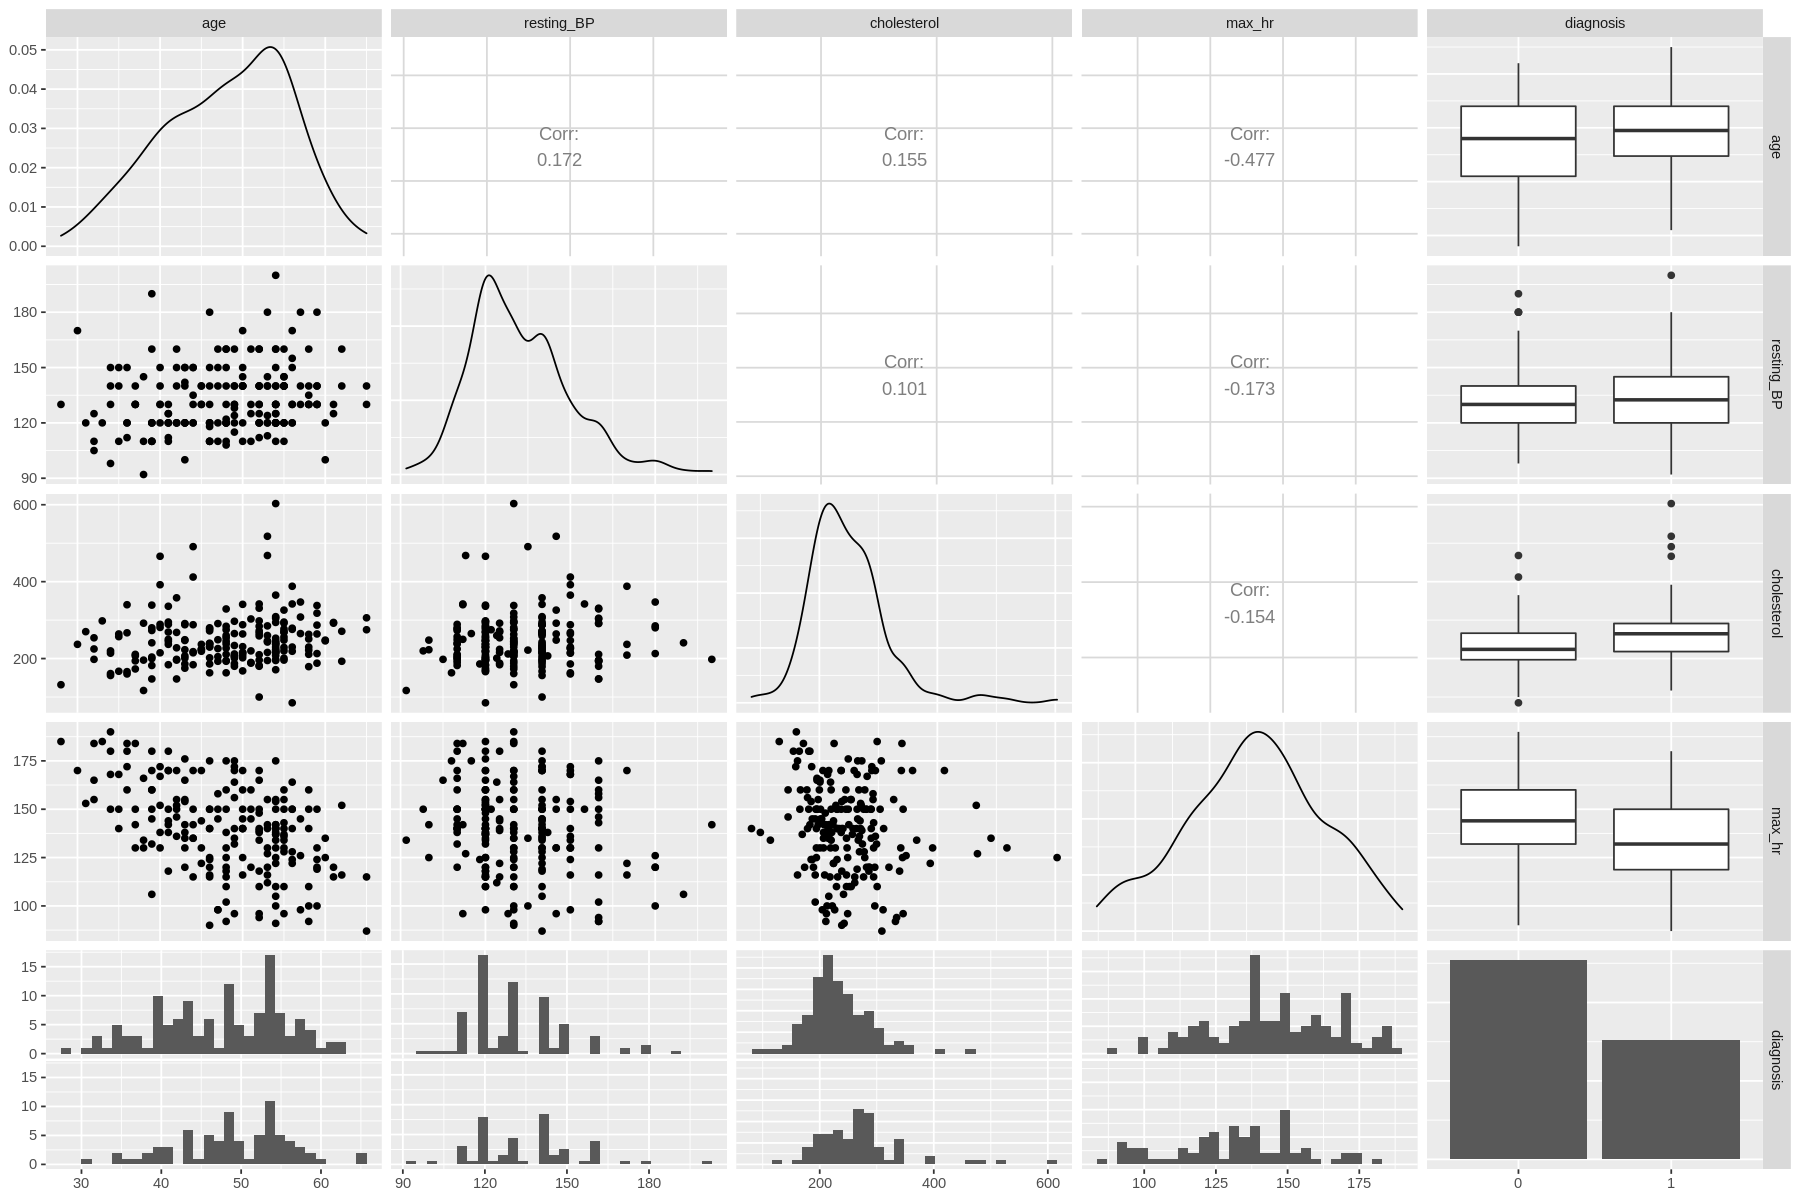

In [18]:
# Create a ggpairs scatterplot of all the columns we are interested in including in our model
options(repr.plot.width = 15, repr.plot.height = 10)
heart_disease_eda <- ggpairs(heart_disease_train)
heart_disease_eda

In [19]:
# Group by diagnosis and find average age, resting blood pressure, cholesteral and maximum heart rate achieved, 
# the number of observations, and percentage of participants in each group

heart_disease_train_table <- heart_disease_train %>%
                                select(age,resting_BP, max_hr, cholesterol, diagnosis)%>%
                                group_by(diagnosis)%>%
                                summarize(avg_age = round(mean(age), digits = 1),
                                          avg_resting_BP = round(mean(resting_BP),digits = 1),
                                          avg_max_hr = round(mean(max_hr),digits = 1),
                                          avg_cholesteral = round(mean(cholesterol),digits = 1),
                                          num_obs = n(),
                                          percentage = round(n()/ nrow(heart_disease_train)*100,digits = 1))

heart_disease_train_table

`summarise()` ungrouping output (override with `.groups` argument)



diagnosis,avg_age,avg_resting_BP,avg_max_hr,avg_cholesteral,num_obs,percentage
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
0,47.4,131.1,145.1,233.7,127,62.6
1,49.1,134.8,131.9,270.3,76,37.4


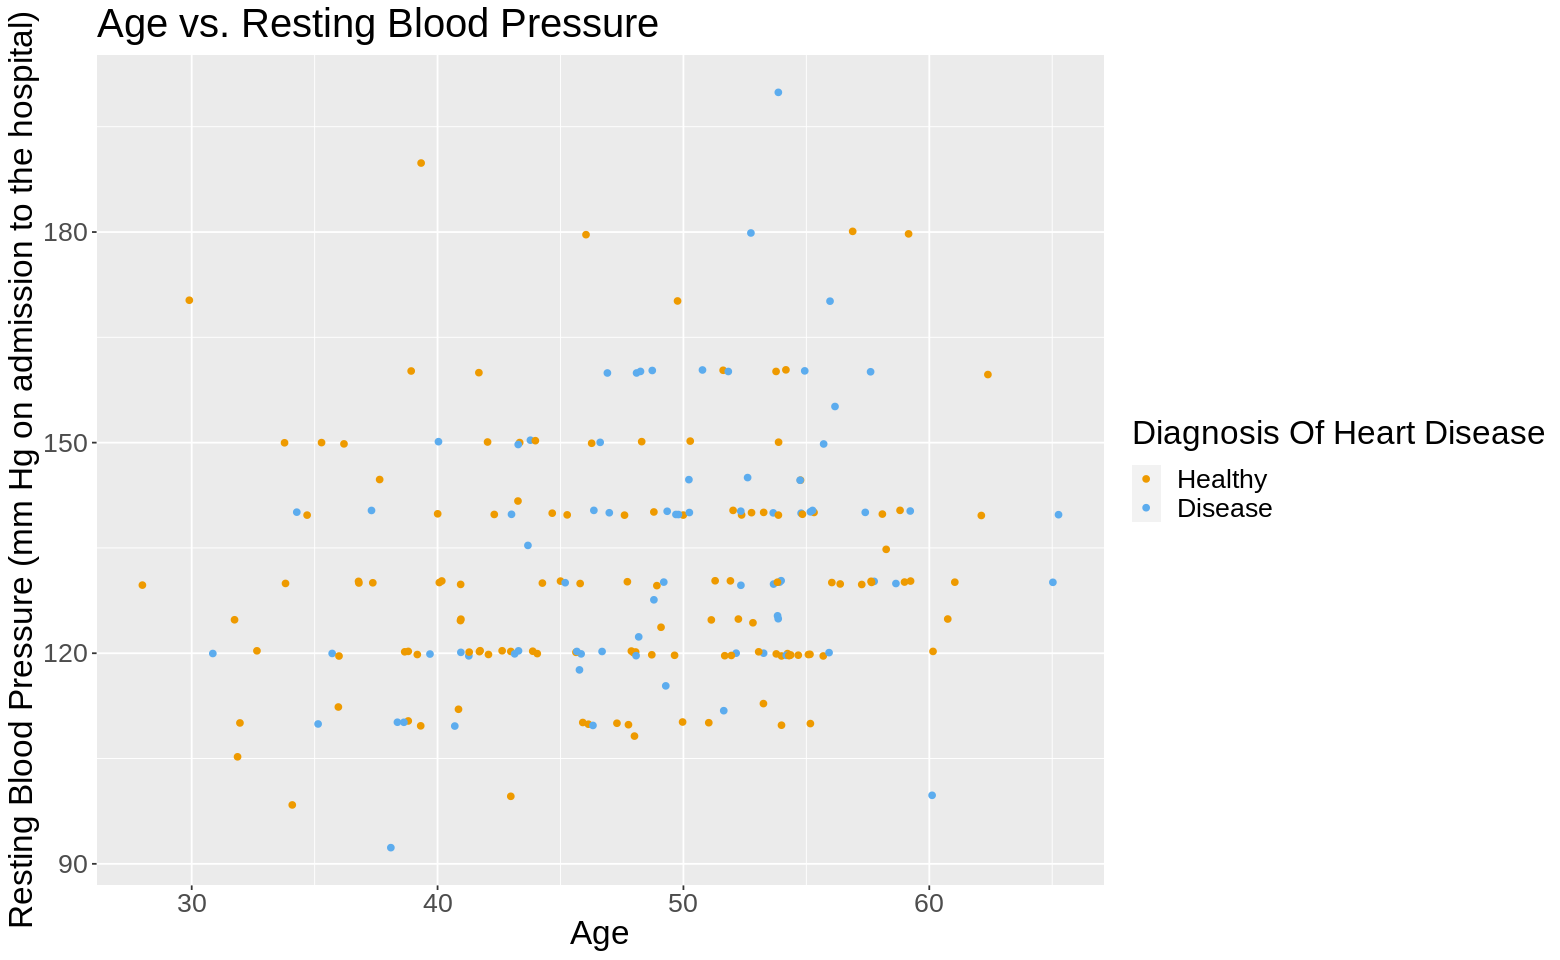

In [20]:
# Plot for age vs. resting blood pressure

options(repr.plot.width = 13, repr.plot.height = 8)

resting_BP_plot <- heart_disease_train %>%
                    ggplot(aes(x = age, y = resting_BP, color = diagnosis))+
                    geom_point(position = "jitter")+
                    labs(x = "Age", y = "Resting Blood Pressure (mm Hg on admission to the hospital)", colour = "Diagnosis Of Heart Disease")+
                    ggtitle("Age vs. Resting Blood Pressure")+
                    theme(text = element_text(size = 20))+
                    scale_y_continuous(labels = scales::comma)+
                    scale_color_manual(labels = c("Healthy", "Diseased"), values = c("orange2", "steelblue2"))
resting_BP_plot

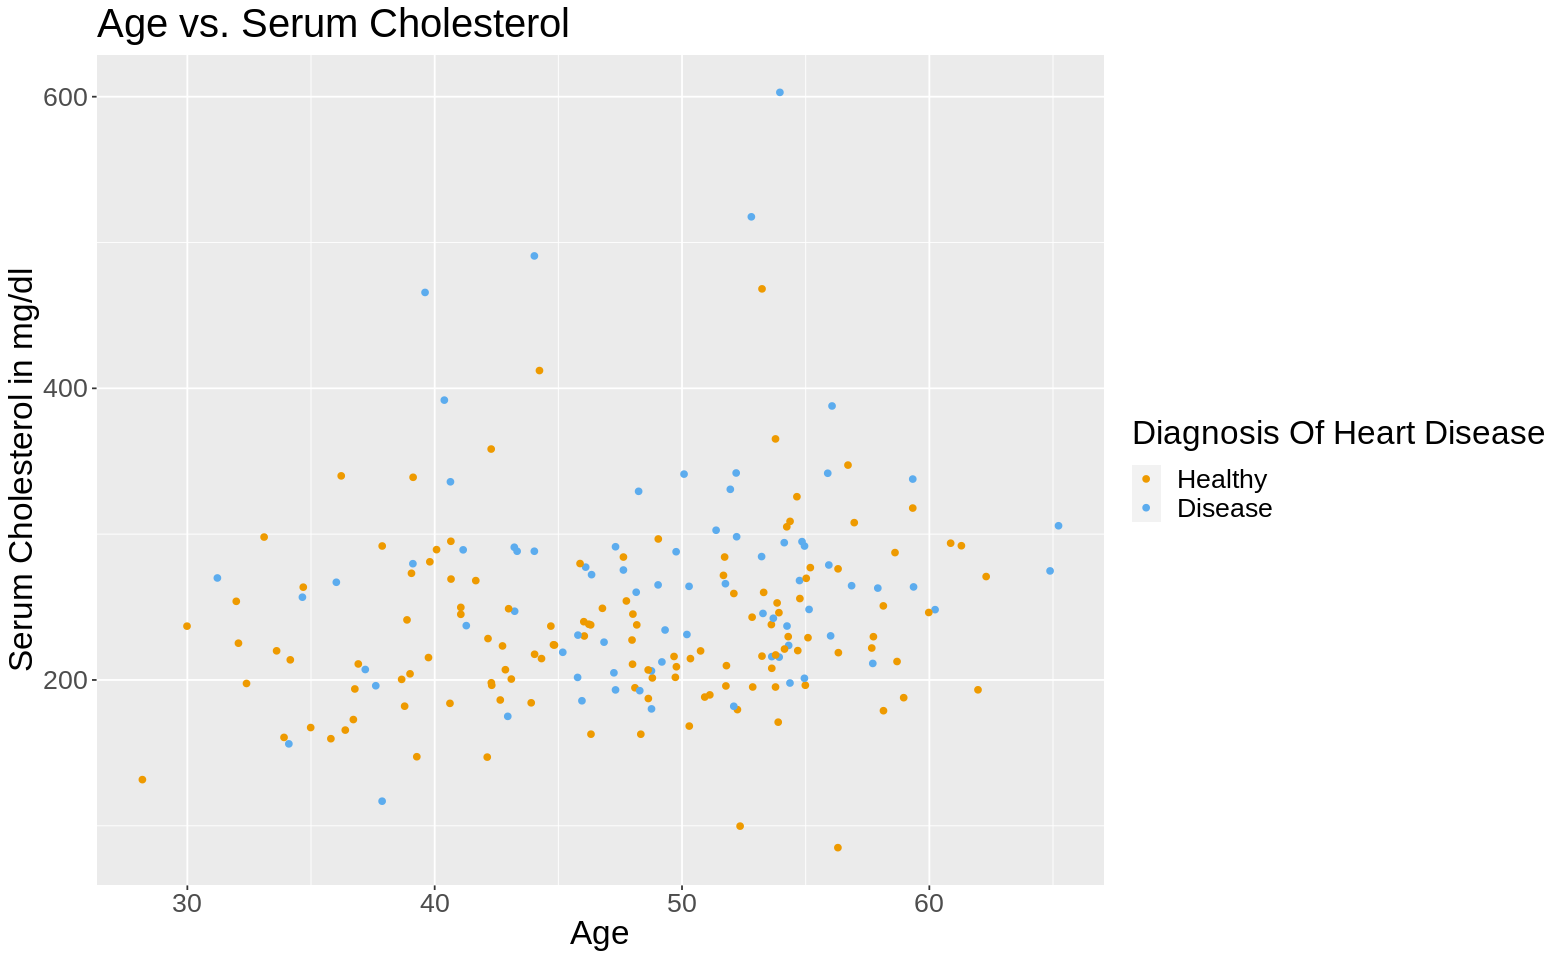

In [21]:
# Plot for age vs. cholesteral

options(repr.plot.width = 13, repr.plot.height = 8)

resting_BP_plot <- heart_disease_train %>%
                    ggplot(aes(x = age, y = cholesterol, color = diagnosis))+
                    geom_point(position = "jitter")+
                    labs(x = "Age", y = "Serum Cholesterol in mg/dl", colour = "Diagnosis Of Heart Disease")+
                    ggtitle("Age vs. Serum Cholesterol")+
                    theme(text = element_text(size = 20))+
                    scale_y_continuous(labels = scales::comma)+
                    scale_color_manual(labels = c("Healthy", "Diseased"), values = c("orange2", "steelblue2"))
resting_BP_plot

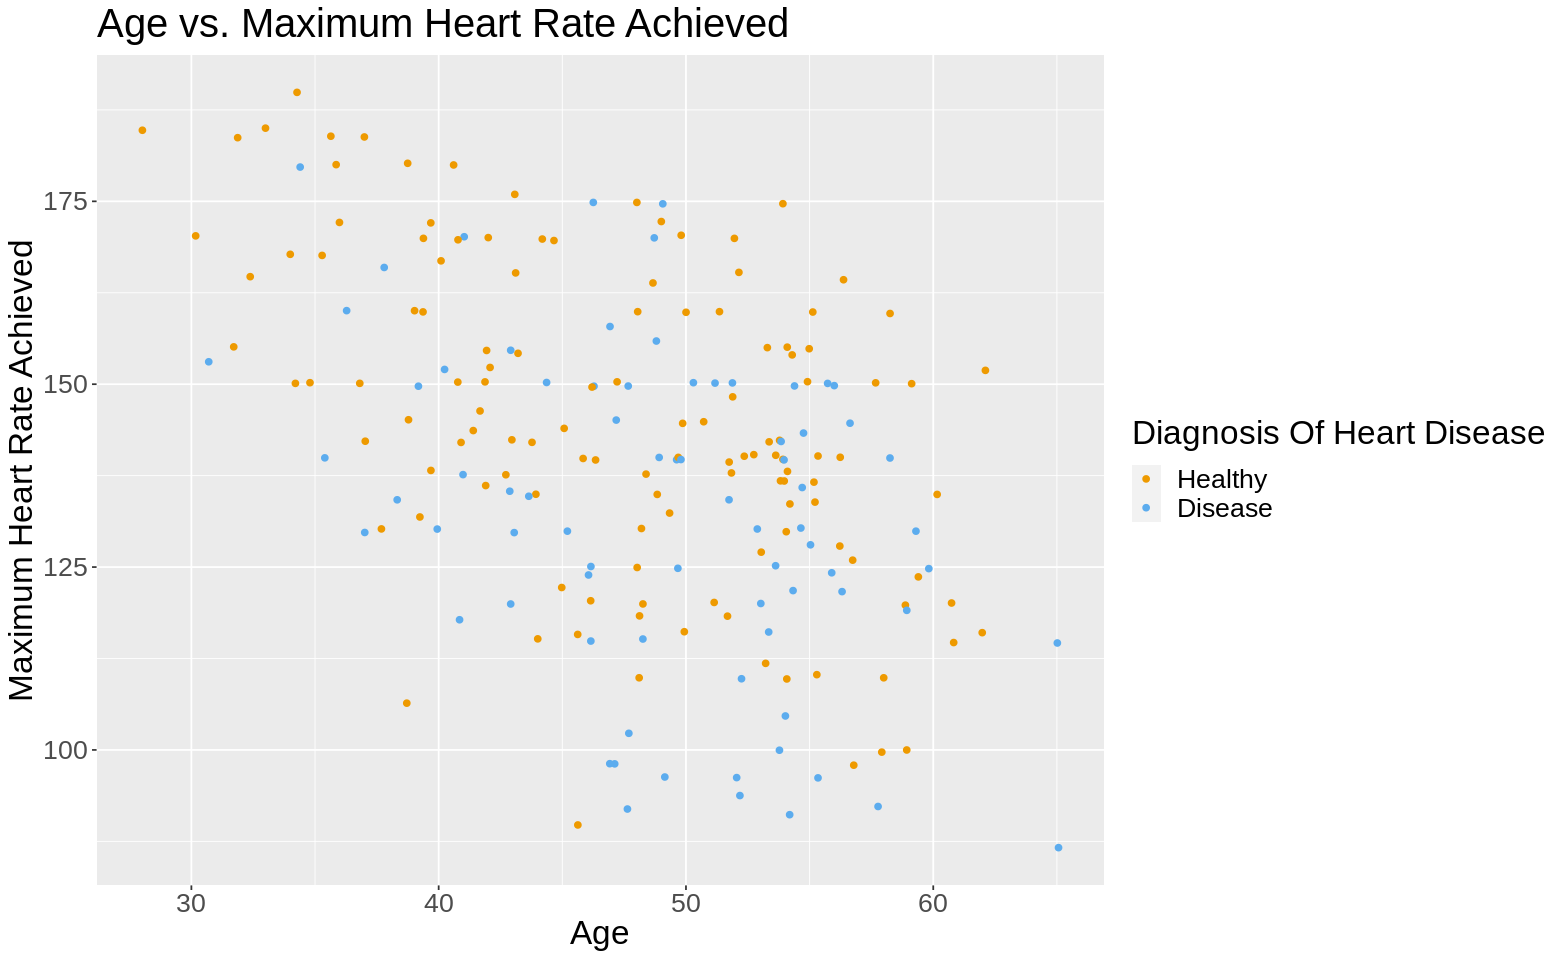

In [22]:
# Plot for age vs. maximum heart rate achieved

options(repr.plot.width = 13, repr.plot.height = 8)

max_hr_plot <- heart_disease_train %>%
                    ggplot(aes(x = age, y = max_hr, color = diagnosis))+
                    geom_point(position = "jitter")+
                    labs(x = "Age", y = "Maximum Heart Rate Achieved", colour = "Diagnosis Of Heart Disease")+
                    ggtitle("Age vs. Maximum Heart Rate Achieved")+
                    theme(text = element_text(size = 20))+
                    scale_y_continuous(labels = scales::comma)+
                    scale_color_manual(labels = c("Healthy", "Disease"), values = c("orange2", "steelblue2"))
max_hr_plot

### Age and Resting Blood Pressure

In [73]:
# Set the seed
set.seed(999) 

# Create the standardization recipe
heart_disease_recipe_1 <- recipe(diagnosis ~ age + resting_BP, data = heart_disease_train) %>%
                        step_scale(all_predictors()) %>%
                        step_center(all_predictors())

# Create the KNN model specification
knn_spec_1 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn")%>%
            set_mode("classification")

# Perform 10-fold cross-validation
heart_disease_vfold_1 <- vfold_cv(heart_disease_train, v = 10, strata = diagnosis)

# Put the recipe and model specification in a workflow
k_vals_1 <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_results_1 <- workflow() %>%
            add_recipe(heart_disease_recipe_1)%>%
            add_model(knn_spec_1) %>%
            tune_grid(resamples = heart_disease_vfold_1, grid = k_vals_1) %>%
            collect_metrics()

! Fold01: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold02: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold03: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold04: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold05: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold06: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold07: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold08: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold09: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold10: internal: No observations were detected in `truth` for level(s): '2', '3...



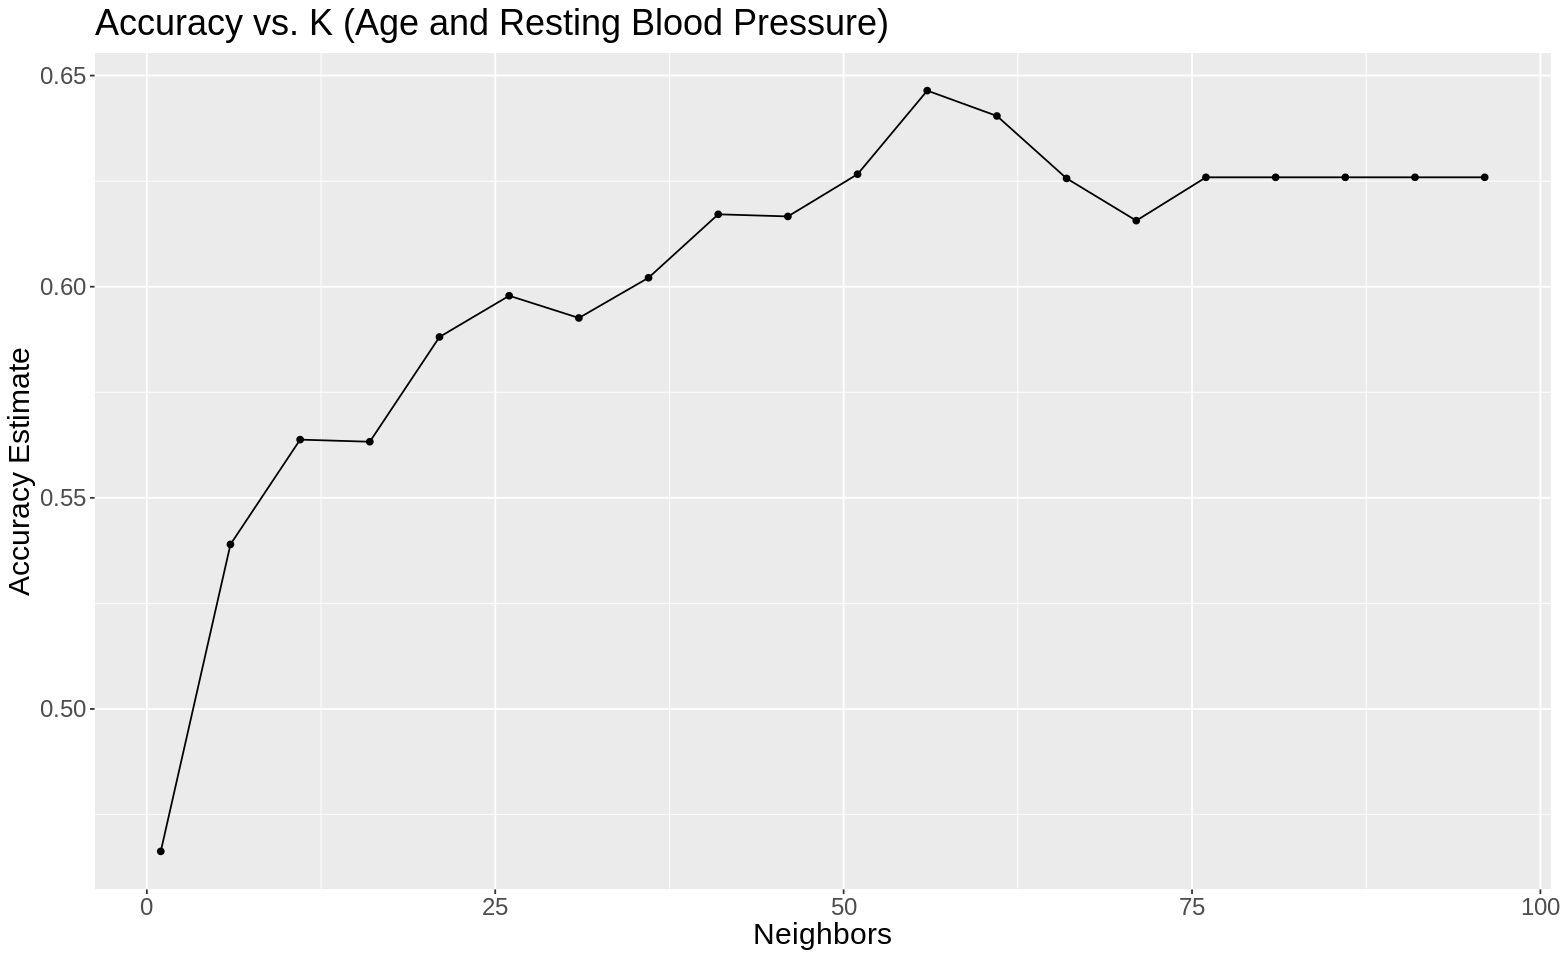

In [74]:
# Filter for accuracy from the .metric column
accuracies_1 <- knn_results_1 %>% 
       filter(.metric == "accuracy")


# Select K by plotting Accuracy vs. K

accuracy_vs_k_1 <- ggplot(accuracies_1, aes(x = neighbors, y = mean))+
                    geom_point()+
                    geom_line()+
                    labs(x = "Neighbors", y = "Accuracy Estimate")+
                    theme(text = element_text(size = 18))+
                    ggtitle("Accuracy vs. K (Age and Resting Blood Pressure)")
accuracy_vs_k_1

In [75]:
# Make a new model specification for the best paramter value and retrain the classifier using the fit function.
knn_spec_1 <- nearest_neighbor(weight_func = "rectangular", neighbors = 56) %>%
                set_engine("kknn") %>%
                set_mode("classification")

knn_fit_1 <- workflow() %>%
            add_recipe(heart_disease_recipe_1)%>%
            add_model(knn_spec_1) %>%
            fit(data = heart_disease_train)

# Predict the labels in the test set
heart_disease_test_predictions_1 <- predict(knn_fit_1, heart_disease_test) %>%
                                    bind_cols(heart_disease_test)

# Compute the accuracy
heart_disease_accuracy_1 <- heart_disease_test_predictions_1 %>%
                            metrics(truth = diagnosis, estimate = .pred_class) %>%
                            filter(.metric == "accuracy")
heart_disease_accuracy_1

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.6567164


### Age and Cholesterol

In [76]:
# Set the seed
set.seed(999) 

# Create the standardization recipe
heart_disease_recipe <- recipe(diagnosis ~ age + cholesterol, data = heart_disease_train) %>%
                        step_scale(all_predictors()) %>%
                        step_center(all_predictors())

# Create the KNN model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn")%>%
            set_mode("classification")

# Perform 10-fold cross-validation
heart_disease_vfold <- vfold_cv(heart_disease_train, v = 10, strata = diagnosis)

# Put the recipe and model specification in a workflow
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_results <- workflow() %>%
            add_recipe(heart_disease_recipe)%>%
            add_model(knn_spec) %>%
            tune_grid(resamples = heart_disease_vfold, grid = k_vals) %>%
            collect_metrics()

! Fold01: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold02: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold03: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold04: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold05: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold06: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold07: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold08: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold09: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold10: internal: No observations were detected in `truth` for level(s): '2', '3...



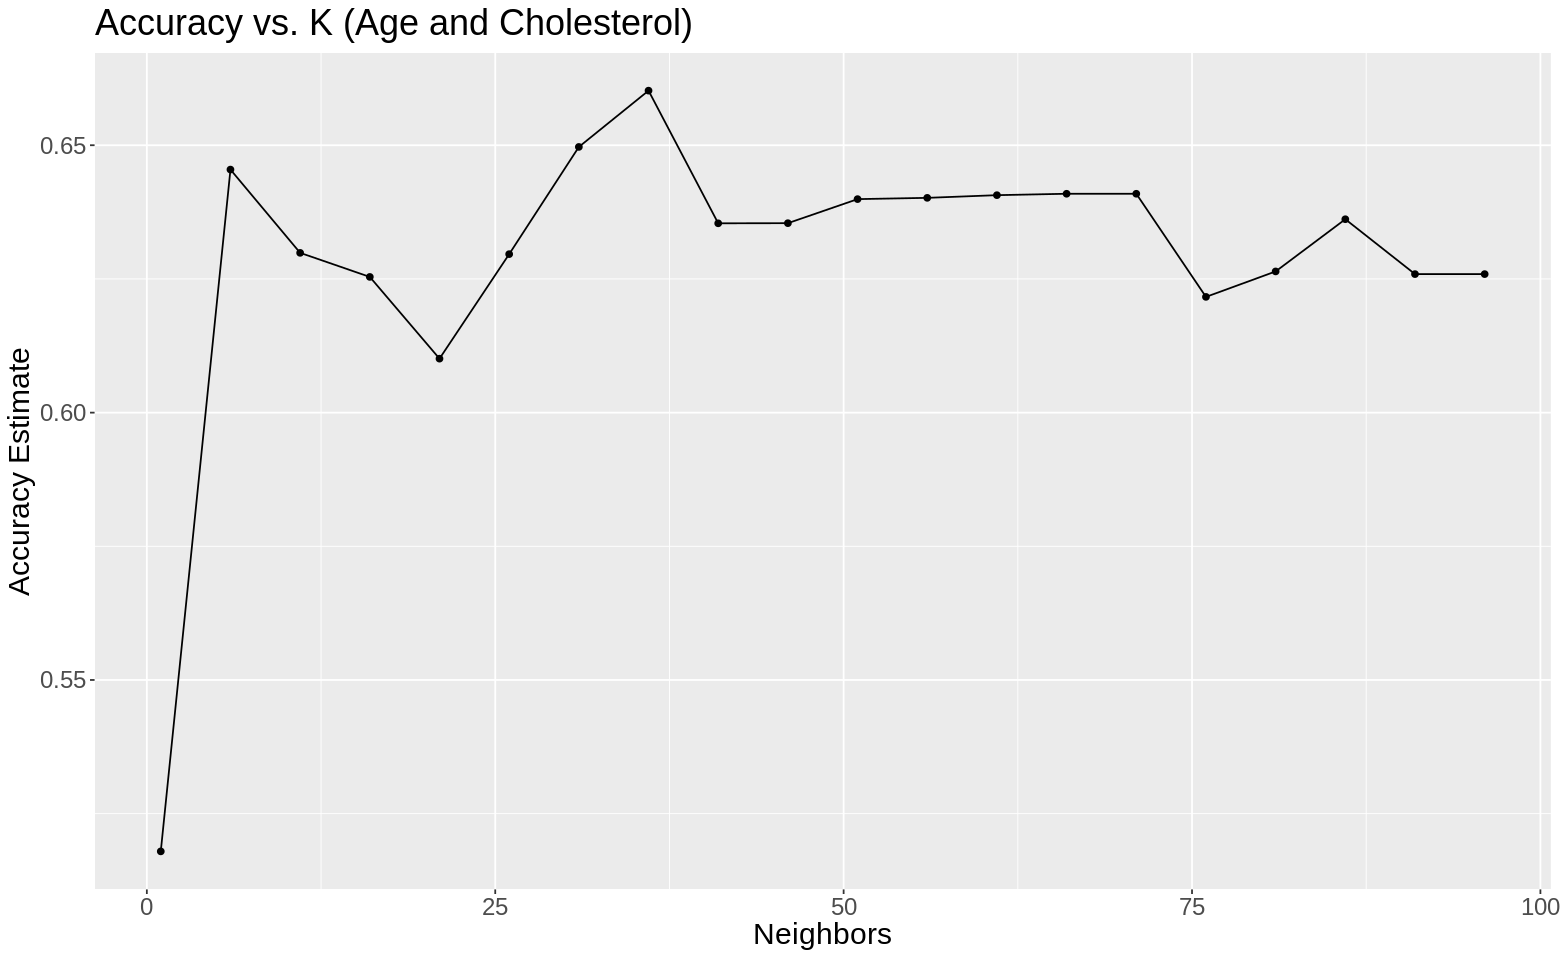

In [77]:
# Filter for accuracy from the .metric column
accuracies <- knn_results %>% 
       filter(.metric == "accuracy")


# Select K by plotting Accuracy vs. K

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
                    geom_point()+
                    geom_line()+
                    labs(x = "Neighbors", y = "Accuracy Estimate")+
                    theme(text = element_text(size = 18))+
                    ggtitle("Accuracy vs. K (Age and Cholesterol)")
accuracy_vs_k

In [70]:
# Make a new model specification for the best paramter value and retrain the classifier using the fit function.
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 37) %>%
                set_engine("kknn") %>%
                set_mode("classification")

knn_fit <- workflow() %>%
            add_recipe(heart_disease_recipe)%>%
            add_model(knn_spec) %>%
            fit(data = heart_disease_train)

# Predict the labels in the test set
heart_disease_test_predictions <- predict(knn_fit, heart_disease_test) %>%
                                    bind_cols(heart_disease_test)

# Compute the accuracy
heart_disease_accuracy <- heart_disease_test_predictions %>%
                            metrics(truth = diagnosis, estimate = .pred_class) %>%
                            filter(.metric == "accuracy")
heart_disease_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.6119403


### Age and Maximum Heart Rate Achieved

In [79]:
# Set the seed
set.seed(999) 

# Create the standardization recipe
heart_disease_recipe_2 <- recipe(diagnosis ~ age + max_hr, data = heart_disease_train) %>%
                        step_scale(all_predictors()) %>%
                        step_center(all_predictors())

# Create the KNN model specification
knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn")%>%
            set_mode("classification")

# Perform 10-fold cross-validation
heart_disease_vfold_2 <- vfold_cv(heart_disease_train, v = 10, strata = diagnosis)

# Put the recipe and model specification in a workflow
k_vals_2 <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_results_2 <- workflow() %>%
            add_recipe(heart_disease_recipe_2)%>%
            add_model(knn_spec_2) %>%
            tune_grid(resamples = heart_disease_vfold_2, grid = k_vals_2) %>%
            collect_metrics()

! Fold01: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold02: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold03: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold04: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold05: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold06: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold07: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold08: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold09: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold10: internal: No observations were detected in `truth` for level(s): '2', '3...



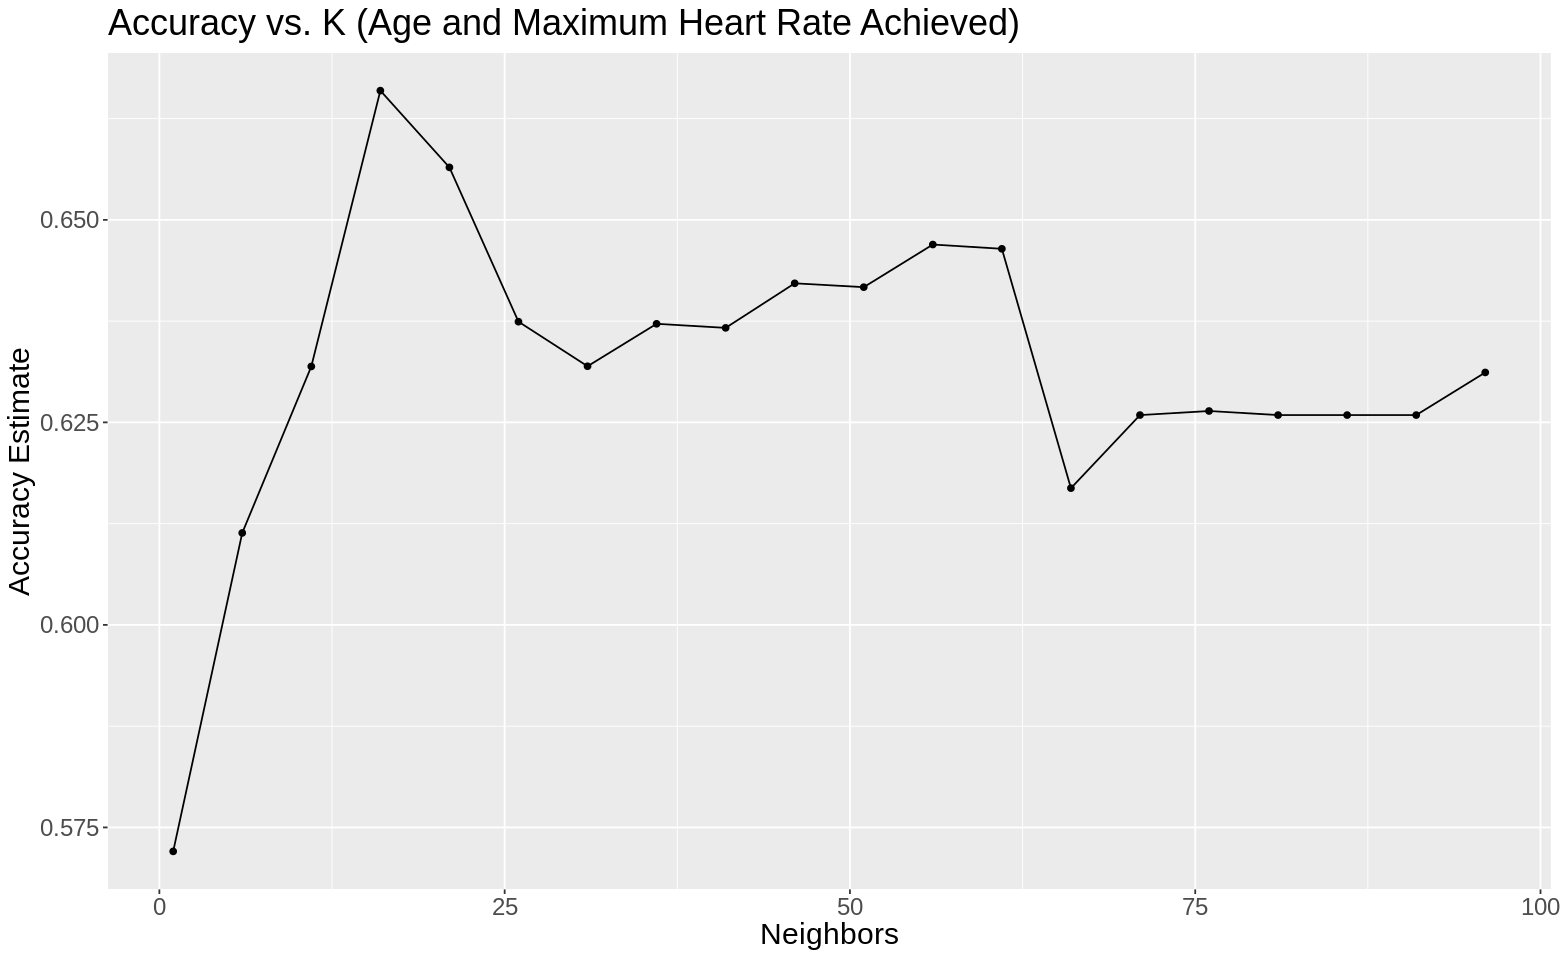

In [84]:
# Filter for accuracy from the .metric column
accuracies_2 <- knn_results_2 %>% 
       filter(.metric == "accuracy")


# Select K by plotting Accuracy vs. K

accuracy_vs_k_2 <- ggplot(accuracies_2, aes(x = neighbors, y = mean))+
                    geom_point()+
                    geom_line()+
                    labs(x = "Neighbors", y = "Accuracy Estimate")+
                    theme(text = element_text(size = 18))+
                    ggtitle("Accuracy vs. K (Age and Maximum Heart Rate Achieved)")
accuracy_vs_k_2

In [92]:
# Make a new model specification for the best paramter value and retrain the classifier using the fit function.
knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 18) %>%
                set_engine("kknn") %>%
                set_mode("classification")

knn_fit_2 <- workflow() %>%
            add_recipe(heart_disease_recipe_2)%>%
            add_model(knn_spec_2) %>%
            fit(data = heart_disease_train)

# Predict the labels in the test set
heart_disease_test_predictions_2 <- predict(knn_fit_2, heart_disease_test) %>%
                                    bind_cols(heart_disease_test)

# Compute the accuracy
heart_disease_accuracy_2 <- heart_disease_test_predictions_2 %>%
                            metrics(truth = diagnosis, estimate = .pred_class) %>%
                            filter(.metric == "accuracy")
heart_disease_accuracy_2

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.6865672
